# Model Training

- **Purpose:** Environment setup and loading/validating feature-engineered dataset for fraud model training  
- **Author:** Devbrew LLC  
- **Last Updated:** October 25, 2025  
- **Status:** In progress  
- **License:** Apache 2.0 (Code) | Non-commercial (Data)

---

## Dataset License Notice

This notebook uses the **IEEE-CIS Fraud Detection dataset** from Kaggle.

**Dataset License:** Non-commercial research use only  
- You must download the dataset yourself from [Kaggle IEEE-CIS Competition](https://www.kaggle.com/c/ieee-fraud-detection)  
- You must accept the competition rules before downloading  
- Cannot be used for commercial purposes  
- Cannot redistribute the raw dataset

**Setup Instructions:** See [`../data_catalog/README.md`](../data_catalog/README.md) for download instructions.

**Code License:** This notebook's code is licensed under Apache 2.0 (open source).

---

## Notebook Configuration

### Environment Setup

We configure the Python environment with standardized settings, import required libraries, and set a fixed random seed for reproducibility. This ensures consistent results across runs and enables reliable experimentation.

These settings establish the foundation for all model training operations.

In [1]:
import warnings
from pathlib import Path
import json
import hashlib
from typing import Dict, Any, Optional, Tuple

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Configuration
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", 100)
pd.set_option("display.max_rows", 100)
pd.set_option("display.float_format", '{:.2f}'.format)

# Plotting configuration
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)
plt.rcParams["font.size"] = 10

# Reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("Environment configured successfully")
print(f"pandas: {pd.__version__}")
print(f"numpy: {np.__version__}")

Environment configured successfully
pandas: 2.3.3
numpy: 2.3.3


### Path Configuration

We define the project directory structure and validate that required processed data from feature engineering exists. The validation ensures we have the necessary inputs before proceeding with training.

This configuration pattern ensures we can locate all required data artifacts from previous pipeline stages.

In [2]:
# Project paths
PROJECT_ROOT = Path.cwd().parent
DATA_DIR = PROJECT_ROOT / "data_catalog"
IEEE_CIS_DIR = DATA_DIR / "ieee-fraud"
PROCESSED_DIR = DATA_DIR / "processed"
NOTEBOOKS_DIR = PROJECT_ROOT / "notebooks"

# Ensure processed directory exists
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)

# Expected artifacts
FEATURES_PATH = PROCESSED_DIR / "train_features.parquet"
FE_METADATA_PATH = PROCESSED_DIR / "feature_engineering_metadata.json"

def validate_required_artifacts():
    """Validate that required artifacts exist before training."""
    path_status = {
        'train_features.parquet': FEATURES_PATH.exists(),
        'feature_engineering_metadata.json': FE_METADATA_PATH.exists()
    }
    print("Artifact Availability Check:")
    for name, exists in path_status.items():
        status = "Found" if exists else "Missing"
        print(f" - {name}: {status}")

    all_exist = all(path_status.values())

    if not all_exist:
        print("\n[WARNING] Some artifacts are missing; ensure feature engineering completed successfully")
    else:
        print("\nAll required artifacts are available")

artifact_status = validate_required_artifacts()

Artifact Availability Check:
 - train_features.parquet: Found
 - feature_engineering_metadata.json: Found

All required artifacts are available


## Load Features & Data Manifest

We load the feature-engineered dataset and validate integrity against recorded metadata. We also create a simple data manifest to document:
- shape
- feature count
- missing values
- target distribution (`isFraud`)
- memory footprint
- file hash (for reproducibility)

### Validation Checklist
- Verify shape matches metadata (590,540 × 432)
- Confirm zero missing values
- Check target distribution (~3.5% fraud rate)
- Validate `TransactionDT` exists for time-based split
- Validate identifiers (`TransactionID`) and target (`isFraud`) are present

In [3]:
def file_sha256(path: Path, chunk_size: int = 2**20) -> Optional[str]:
    """Compute SHA-256 hash of a file; returns None if file missing"""
    if not path.exists():
        return None
    h = hashlib.sha256()
    with path.open("rb") as f:
        while True:
            chunk = f.read(chunk_size)
            if not chunk:
                break
            h.update(chunk)
    return h.hexdigest()

def build_data_manifest(df: pd.DataFrame, file_path: Path, fe_meta: Optional[Dict[str, Any]]) -> Dict[str, Any]:
    """Create a manifest capturing data properties for reproducibility."""
    manifest: Dict[str, Any] = {
        "generated_at": pd.Timestamp.now().isoformat(),
        "source_file": str(file_path),
        "source_hash_sha256": file_sha256(file_path),
        "rows": int(df.shape[0]),
        "columns": int(df.shape[1]),
        "memory_gb": float(df.memory_usage().sum() / 1e9),
        "dtypes_summary": df.dtypes.astype(str).value_counts().to_dict(),
        "null_values_total": int(df.isna().sum().sum()),
        "columns_with_nulls": df.columns[df.isna().any()].tolist(),
        "target": "isFraud",
        "target_distribution": df["isFraud"].value_counts(dropna=False).to_dict() if "isFraud" in df.columns else {},
        "target_rate": float(df["isFraud"].mean()) if "isFraud" in df.columns else None,
        "has_transactiondt": bool("TransactionDT" in df.columns),
        "has_transactionid": bool("TransactionID" in df.columns),
        "random_state": RANDOM_STATE,
    }

    if fe_meta:
        manifest["feature_engineering_metadata"] = {
            "total_features_expected": fe_meta.get("total_features"),
            "dataset_shape_expected": fe_meta.get("dataset_shape"),
            "engineering_date": fe_meta.get("engineering_date"),
        }

    return manifest

# Load feature engineering metadata if available
fe_meta = None
if FE_METADATA_PATH.exists():
    with open(FE_METADATA_PATH, "r") as f:
        fe_meta = json.load(f)

print("Loading Feature-Engineered Data...")
if not FEATURES_PATH.exists():
    raise FileNotFoundError(f"Missing features file: {FEATURES_PATH}")

df = pd.read_parquet(FEATURES_PATH)
print(f"Loaded features: {df.shape[0]:,} rows x {df.shape[1]:,} columns")
print(f"Memory usage: {df.memory_usage().sum() / 1e9:.2f} GB")

# Basic target info
if "isFraud" in df.columns:
    print("\nTarget Distribution:")
    print(pd.Series(df["isFraud"]).value_counts())
    print(f"Fraud rate: {df['isFraud'].mean() * 100:.2f}%")
else:
    print("\n[WARNING] 'isFraud' target column not found in features dataset")

# Data check vs metadata
if fe_meta and "dataset_shape" in fe_meta:
    expected_rows, expected_cols = fe_meta["dataset_shape"]
    ok_shape = (df.shape[0] == expected_rows) and (df.shape[1] == expected_cols)
    print(f"\nShape validation vs metadata: {'PASS' if ok_shape else 'FAIL'}")
    print(f" - (Expected {expected_rows:,} x {expected_cols:,} columns, got {df.shape[0]:,} x {df.shape[1]:,} columns)")
else:
    print("\n[WARNING] Feature engineering metadata not availables for shape validation")

# Nulls
total_nulls = int(df.isnull().sum().sum())
print(f"\nTotal missing values: {total_nulls:,}")

# Key column presence
print(f"Has TransactionDT: {'Yes' if 'TransactionDT' in df.columns else 'No'}")
print(f"Has TransactionID: {'Yes' if 'TransactionID' in df.columns else 'No'}")
    

# Dtypes quick summary
dtype_counts = df.dtypes.astype(str).value_counts()
print("\nDtype Summary:")
for dtype, count in dtype_counts.items():
    print(f" - {dtype}: {count}")

# Build and save manifest
manifest = build_data_manifest(df, FEATURES_PATH, fe_meta)

# Save manifest to data catalog
MANIFEST_PATH = PROCESSED_DIR / "training_data_manifest.json"
MANIFEST_PATH.parent.mkdir(parents=True, exist_ok=True)
with open(MANIFEST_PATH, "w") as f:
    json.dump(manifest, f, indent=4)
print(f"\nTraining data manifest saved to: {MANIFEST_PATH}")

Loading Feature-Engineered Data...
Loaded features: 590,540 rows x 432 columns
Memory usage: 2.04 GB

Target Distribution:
isFraud
0    569877
1     20663
Name: count, dtype: int64
Fraud rate: 3.50%

Shape validation vs metadata: PASS
 - (Expected 590,540 x 432 columns, got 590,540 x 432 columns)

Total missing values: 0
Has TransactionDT: Yes
Has TransactionID: Yes

Dtype Summary:
 - float64: 394
 - object: 29
 - int64: 9

Training data manifest saved to: /Users/joekariuki/Documents/Research/Projects/devbrew-payments-fraud-sanctions/data_catalog/processed/training_data_manifest.json


### Notes

- Shapes validated against [feature_engineering_metadata.json](../data_catalog/processed/feature_engineering_metadata.json): expected `(590,540 × 432)`.  
- `TransactionDT` presence is required for time-based splits in train/test/validation split.  
- We persist a `training_data_manifest.json` documenting data properties and file hash for reproducibility.  

## Train/Validation/Test Split (Time-Based)

We perform a chronological split to respect temporal causality in fraud detection. Random splitting would allow the model to see future data during training, inflating performance metrics and violating real-world deployment conditions.

We split the data into 60% train (earliest transactions), 20% validation (middle period), and 20% test (most recent transactions). This simulates production deployment where models score transactions as they arrive over time, and ensures fraudsters' evolving tactics are properly reflected in our evaluation.

This approach follows industry standards for fraud detection in payment systems and meets regulatory requirements for model validation.

In [4]:
SPLITS_DIR = PROCESSED_DIR / "splits"
SPLITS_DIR.mkdir(parents=True, exist_ok=True)

def temporal_split(
    df_in: pd.DataFrame, 
    ts_col: str = "TransactionDT",
    id_col: str = "TransactionID",
    target_col: str = "isFraud",
    train_frac: float = 0.60,
    val_frac: float = 0.20,
    ) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame, Dict[str, Any]]:
    """
    Perform chronological time-based split with temporal leak prevention for fraud detection.
    
    Ensures training data is strictly earlier than validation/test data. This is critical for
    fraud models where future patterns must not leak into training. Common issue in
    production: models trained with random splits show inflated metrics but fail in
    real-time scoring due to temporal leakage.
    
    Parameters:
        df_in: Input dataframe with transactions
        ts_col: Timestamp column for temporal ordering (default: "TransactionDT")
        id_col: Transaction ID column (default: "TransactionID")
        target_col: Binary fraud label (default: "isFraud")
        train_frac: Training fraction (default: 0.60)
        val_frac: Validation fraction (default: 0.20, test gets remainder)
    
    Returns:
        train_df, val_df, test_df: Chronologically split dataframes
        splits_df: Metadata with split labels for visualization
        stats: Comprehensive dict with:
            - Split metrics and temporal boundaries
            - Class distribution and drift analysis (fraud rate shifts)
            - Validation checks (no temporal leakage, no ID overlap)
            - Dataset provenance for reproducibility
    
    Validations performed:
        - Strict temporal ordering: train_max < val_min < test_max
        - No transaction ID overlap between splits
        - Fraud rate drift monitoring (flags if >0.5pp shift between splits)
    """
    # Sort chronologically to ensure temporal ordering for time-series split
    df_sorted = df_in.sort_values(ts_col).reset_index(drop=True)

    # Compute split indices based on configured fractions
    n = len(df_sorted)
    train_end = int(n * train_frac)
    val_end = int(n * (train_frac + val_frac))

    train_df = df_sorted.iloc[:train_end]
    val_df = df_sorted.iloc[train_end:val_end]
    test_df = df_sorted.iloc[val_end:]

    # Create split labels dataframe for visualization and distribution analysis
    split_labels = (['train'] * len(train_df)) + \
                  (['val'] * len(val_df)) + \
                  (['test'] * len(test_df))
    splits_df = df_sorted[[id_col, ts_col, target_col]].copy()
    splits_df['split'] = split_labels

    # Validate temporal boundaries: critical check for preventing data leakage
    train_max_ts = float(train_df[ts_col].max())
    val_min_ts = float(val_df[ts_col].min())
    val_max_ts = float(val_df[ts_col].max())
    test_min_ts = float(test_df[ts_col].min())

    no_temporal_leak_train_val = train_max_ts < val_min_ts
    no_temporal_leak_val_test = val_max_ts < test_min_ts 

    # Verify no transaction ID overlap across splits
    train_ids = set(train_df[id_col].tolist())
    val_ids = set(val_df[id_col].tolist())
    test_ids = set(test_df[id_col].tolist())
    
    no_id_overlap = (len(train_ids & val_ids) == 0) and \
                    (len(train_ids & test_ids) == 0) and \
                    (len(val_ids & test_ids) == 0)

    # Compute fraud rate drift across splits to monitor distribution stability
    def rate(d: pd.DataFrame) -> float:
        """Calculate fraud rate (mean of binary target)"""
        return float(d[target_col].mean() if len(d) else float('nan'))
    
    train_rate = rate(train_df)
    val_rate = rate(val_df)
    test_rate = rate(test_df)

    drift_train_val_pp = abs(train_rate - val_rate) * 100
    drift_train_test_pp = abs(train_rate - test_rate) * 100
    drift_val_test_pp = abs(val_rate - test_rate) * 100
    
    # Assemble comprehensive statistics and validation results
    try:
        source_hash = manifest.get("source_hash_sha256") if isinstance(manifest, dict) else None
    except NameError:
        source_hash = None
    
    stats: Dict[str, Any] = {
        "method": "time_chronological_split",
        "fractions": {
            "train": train_frac,
            "val": val_frac,
            "test": 1.0 - train_frac - val_frac
        },
        "counts": {
            "train": int(len(train_df)),
            "val": int(len(val_df)),
            "test": int(len(test_df)),
            "total": int((n))
        },
        "timestamp_cutoffs": {
            "train_max": train_max_ts,
            "val_min": val_min_ts,
            "val_max": val_max_ts,
            "test_min": test_min_ts
        },
        "class_rates": {
            "train_rate": train_rate,
            "val_rate": val_rate,
            "test_rate": test_rate
        },
        "drift_pp": {
            "train_vs_val": drift_train_val_pp,
            "train_vs_test": drift_train_test_pp,
            "val_vs_test": drift_val_test_pp
        },
        "checks": {
            "no_temporal_leak_train_val": bool(no_temporal_leak_train_val),
            "no_temporal_leak_val_test": bool(no_temporal_leak_val_test),
            "no_overlap_by_id": bool(no_id_overlap),
            "fraud_rate_similarity_within_0_5_pp": bool((drift_train_val_pp <= 0.5) and (drift_val_test_pp <= 0.5))
        },
        "dataset_provenance": {
            "features_path": str(FEATURES_PATH),
            "source_hash_sha256": source_hash or file_sha256(FEATURES_PATH),
            "random_state": RANDOM_STATE
        }
    }

    return train_df, val_df, test_df, splits_df, stats

### Execute Split and Persist Artifacts

We execute the temporal split, save the split indices for reproducibility, and validate data quality checks.

**Key Industry Context:**
- Random splits can inflate model performance by 10-20 percentage points
- Regulatory frameworks (SR 11-7, Model Risk Management) require temporal validation
- Production fraud models must handle concept drift as fraudsters adapt tactics

In [5]:
# Execute the temporal split
train_df, val_df, test_df, splits_index_df, split_stats = temporal_split(df)

# Persists split indices and metadata
splits_index_path = SPLITS_DIR / "temporal_splits.csv"
splits_index_df[['TransactionID', 'split']].to_csv(splits_index_path, index=False)

for name, part in [('train', train_df), ('val', val_df), ('test', test_df)]:
    out_path = SPLITS_DIR / f"{name}_ids.csv"
    out_path.write_text("TransactionID\n" + "\n" .join(part["TransactionID"].astype(str).tolist()))

with open(SPLITS_DIR / "splits_metadata.json", "w") as f:
    json.dump(split_stats, f, indent=4)

# Summary
print("Time-based split complete. Summary:")
print(f" - Counts: train={split_stats['counts']['train']:,}, val={split_stats['counts']['val']:,}, test={split_stats['counts']['test']:,}")
print(" - Timestamp cutoffs:")
print(f"   - train_max < val_min < test_min => {split_stats['checks']['no_temporal_leak_train_val']} & {split_stats['checks']['no_temporal_leak_val_test']}")
print(f" - Fraud rates (%):")
print(f"   - train={split_stats['class_rates']['train_rate']*100:.2f}, val={split_stats['class_rates']['val_rate']*100:.2f}, test={split_stats['class_rates']['test_rate']*100:.2f}")
print(f" - Drift (pp):")
print(f"   - train-vs-val={split_stats['drift_pp']['train_vs_val']:.3f}, train-vs-test={split_stats['drift_pp']['train_vs_test']:.3f}, val-vs-test={split_stats['drift_pp']['val_vs_test']:.3f}")
print(f" - No overlap by ID: {split_stats['checks']['no_overlap_by_id']}")
print(f" - Fraud rate similarity within ±0.5pp (train/val and val/test): {split_stats['checks']['fraud_rate_similarity_within_0_5_pp']}")
print(f"Artifacts saved to: {SPLITS_DIR}")

Time-based split complete. Summary:
 - Counts: train=354,324, val=118,108, test=118,108
 - Timestamp cutoffs:
   - train_max < val_min < test_min => True & True
 - Fraud rates (%):
   - train=3.38, val=3.90, test=3.44
 - Drift (pp):
   - train-vs-val=0.521, train-vs-test=0.058, val-vs-test=0.463
 - No overlap by ID: True
 - Fraud rate similarity within ±0.5pp (train/val and val/test): False
Artifacts saved to: /Users/joekariuki/Documents/Research/Projects/devbrew-payments-fraud-sanctions/data_catalog/processed/splits


### Data Quality Validation

We assert critical data quality checks that would fail a production model review:
- **Temporal leakage prevention**: Ensures no future data contaminates training
- **ID uniqueness**: Prevents same transaction appearing in multiple splits  
- **Distribution monitoring**: Flags significant fraud rate shifts requiring investigation

These checks align with model governance requirements at financial institutions.

In [6]:
assert split_stats["checks"]["no_temporal_leak_train_val"], "Temporal leak between train and val!"
assert split_stats["checks"]["no_temporal_leak_val_test"], "Temporal leak between val and test!"
assert split_stats["checks"]["no_overlap_by_id"], "Transaction ID overlap across splits!"
if not split_stats["checks"]["fraud_rate_similarity_within_0_5_pp"]:
    print(f"[WARNING] Fraud rate drift between exceeds ±0.5pp. Investigate distribution shift or adjust boundaries")

[WARNING] Fraud rate drift between exceeds ±0.5pp. Investigate distribution shift or adjust boundaries


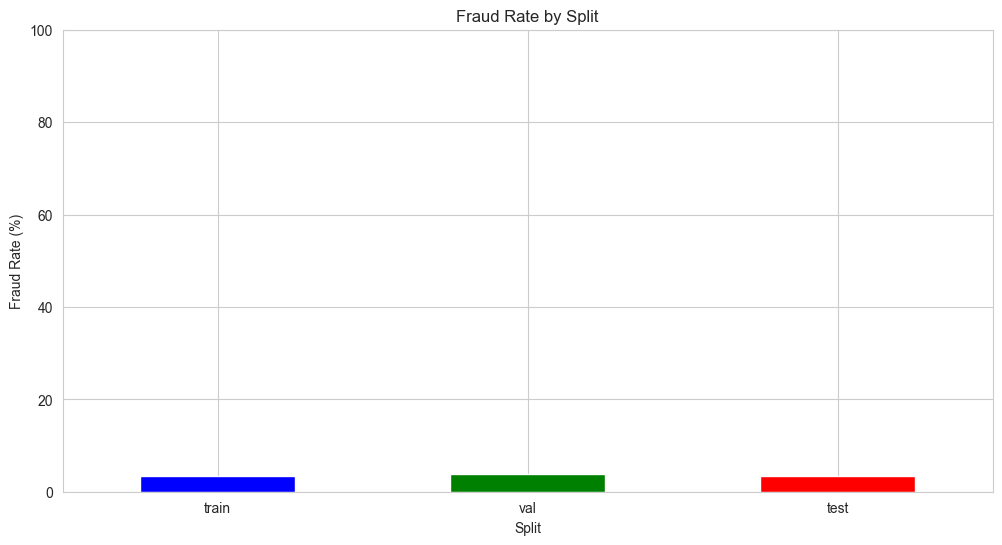

In [7]:
# Visual check of fraud rate by split
split_rates = pd.Series({
    "train": split_stats["class_rates"]["train_rate"] * 100,
    "val": split_stats["class_rates"]["val_rate"] * 100,
    "test": split_stats["class_rates"]["test_rate"] * 100
})

ax = split_rates.plot(kind="bar", rot=0, color=["blue", "green", "red"])
ax.set_title("Fraud Rate by Split")
ax.set_xlabel("Split")
ax.set_ylabel("Fraud Rate (%)")
ax.set_ylim(0, 100)
plt.show()


### Notes

- Fraud rate drift between train/validation is **0.521pp** (0.021pp above threshold), indicating modest distribution shift typical of evolving fraud patterns over time
- This reflects realistic temporal evolution in fraud patterns common in production systems
- Validation/test drift is **0.463pp** (within threshold)
- All critical temporal leakage checks passed; splits maintain strict chronological ordering
- Model performance monitoring in production should track similar drift metrics

## Feature Selection & Preparation

We separate features from the target variable and exclude non-predictive columns that would cause leakage or serve purely as identifiers. This ensures our model learns from legitimate predictive signals rather than artifacts of data collection.

We identify and document the feature set to maintain consistency across training, validation, and test splits. This feature registry serves as the contract between model training and production inference.

Tree-based models like LightGBM handle categorical features natively, avoiding the curse of dimensionality from one-hot encoding while preserving categorical information.

In [8]:
# Identify columns to exclude from modeling
EXCLUDE_COLS = ['TransactionID', 'TransactionDT', 'isFraud']

# Verify exclusion columns exist
missing_cols = [col for col in EXCLUDE_COLS if col not in train_df.columns]

if missing_cols:
    raise ValueError(f"Expected columns not found: {missing_cols}")

# Get all column names
all_cols = train_df.columns.tolist()

# Extract feature columns (everything except target and identifiers)
feature_cols = [col for col in all_cols if col not in EXCLUDE_COLS]

print(f"Total columns: {len(all_cols)}")
print(f"Excluded columns: {len(EXCLUDE_COLS)} → {EXCLUDE_COLS}")
print(f"Feature columns: {len(feature_cols)}")
print(f"\nTarget variable: isFraud")
print(f"Training samples: {len(train_df):,}")
print(f"Validation samples: {len(val_df):,}")
print(f"Test samples: {len(test_df):,}")

Total columns: 432
Excluded columns: 3 → ['TransactionID', 'TransactionDT', 'isFraud']
Feature columns: 429

Target variable: isFraud
Training samples: 354,324
Validation samples: 118,108
Test samples: 118,108


In [9]:
# Separate features (X) and target (y)
X_train = train_df[feature_cols].copy()
y_train = train_df['isFraud'].copy()

X_val = val_df[feature_cols].copy()
y_val = val_df['isFraud'].copy()

X_test = test_df[feature_cols].copy()
y_test = test_df['isFraud'].copy()

# Verify shapes
print(f"Feature matrix shapes:")
print(f" - X_train: {X_train.shape}")
print(f" - X_val: {X_val.shape}")
print(f" - X_test: {X_test.shape}")

# Verify target shapes
print(f"\nTarget vectors shapes:")
print(f" - y_train: {y_train.shape} (fraud rate: {y_train.mean()*100:.2f}%)")
print(f" - y_val: {y_val.shape} (fraud rate: {y_val.mean()*100:.2f}%)")
print(f" - y_test: {y_test.shape} (fraud rate: {y_test.mean()*100:.2f}%)")

# Verify no missing values in features
train_nulls = X_train.isnull().sum().sum()
val_nulls = X_val.isnull().sum().sum()
test_nulls = X_test.isnull().sum().sum()

print("\nMissing values check:")
print(f" - X_train: {train_nulls:,}")
print(f" - X_val: {val_nulls:,}")
print(f" - X_test: {test_nulls:,}")

if train_nulls > 0 or val_nulls > 0 or test_nulls > 0:
    print(f"\n[WARNING] Missing values detected in feature matrices")

Feature matrix shapes:
 - X_train: (354324, 429)
 - X_val: (118108, 429)
 - X_test: (118108, 429)

Target vectors shapes:
 - y_train: (354324,) (fraud rate: 3.38%)
 - y_val: (118108,) (fraud rate: 3.90%)
 - y_test: (118108,) (fraud rate: 3.44%)

Missing values check:
 - X_train: 0
 - X_val: 0
 - X_test: 0


In [10]:
# Identify numeric and categorical features
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()

print(f"\nFeature type breakdown:")
print(f" - Numeric features: {len(numeric_features)}")
print(f" - Categorical features: {len(categorical_features)}")

# Display sample categorical features for verification
if categorical_features:
    print("\nSample categorical features (first 10):")
    for feat in categorical_features[:10]:
        unique_count = X_train[feat].nunique()
        print(f" - {feat}: {unique_count} unique values")
    
    if len(categorical_features) > 10:
        print(f" ... and {len(categorical_features) - 10} more")
else:
    print("\nNo categorical features detected")

# Display sample numeric features
print(f"\nSample numeric features (first 10):")
for feat in numeric_features[:10]:
    print(f" - {feat}")

if len(numeric_features) > 10:
    print(f" ... and {len(numeric_features) -10} more")


Feature type breakdown:
 - Numeric features: 400
 - Categorical features: 29

Sample categorical features (first 10):
 - ProductCD: 5 unique values
 - card4: 5 unique values
 - card6: 5 unique values
 - P_emaildomain: 60 unique values
 - R_emaildomain: 61 unique values
 - M1: 3 unique values
 - M2: 3 unique values
 - M3: 3 unique values
 - M4: 4 unique values
 - M5: 3 unique values
 ... and 19 more

Sample numeric features (first 10):
 - TransactionAmt
 - card1
 - card2
 - card3
 - card5
 - addr1
 - addr2
 - dist1
 - C1
 - C2
 ... and 390 more


In [11]:
# Create comprehensive feature registry for reproducibility
feature_registry = {
    "created_at": pd.Timestamp.now().isoformat(),
    "total_features": len(feature_cols),
    "numeric_features": numeric_features,
    "categorical_features": categorical_features,
    "excluded_columns": EXCLUDE_COLS,
    "feature_columns": feature_cols,
    "target_variable": "isFraud",
    "dataset_info": {
        "train_samples": int(len(X_train)),
        "val_samples": int(len(X_val)),
        "test_samples": int(len(X_test)),
        "fraud_rate_train": float(y_train.mean()),
        "fraud_rate_val": float(y_val.mean()),
        "fraud_rate_test": float(y_test.mean()),
    },
    "dtype_info": {
        "numeric_count": len(numeric_features),
        "categorical_count": len(categorical_features),
    },
}

# Save feature registry
FEATURE_REGISTRY_PATH = PROCESSED_DIR / "feature_registry.json"
with open(FEATURE_REGISTRY_PATH, "w") as f:
    json.dump(feature_registry, f, indent=4)

print(f"Feature registry saved to: {FEATURE_REGISTRY_PATH}")
print(f"\nRegistry summary:")
print(f" - Created at: {feature_registry['created_at']}")
print(f" - Total features: {feature_registry['total_features']}")
print(f" - Numeric: {feature_registry['dtype_info']['numeric_count']}")
print(f" - Categorical: {feature_registry['dtype_info']['categorical_count']}")
print(f" - Target variable: {feature_registry['target_variable']}")

Feature registry saved to: /Users/joekariuki/Documents/Research/Projects/devbrew-payments-fraud-sanctions/data_catalog/processed/feature_registry.json

Registry summary:
 - Created at: 2025-10-25T06:08:54.385428
 - Total features: 429
 - Numeric: 400
 - Categorical: 29
 - Target variable: isFraud


In [12]:
# Pre-modeling validation
assert 'isFraud' not in X_train.columns, "Target variable found in feature matrix"
assert 'isFraud' not in X_val.columns, "Target variable found in validation features"
assert 'isFraud' not in X_test.columns, "Target variable found in test features"

leaked_cols = [col for col in EXCLUDE_COLS if col in X_train.columns]
assert len(leaked_cols) == 0, f"Excluded columns found in features: {leaked_cols}"

assert set(X_train.columns) == set(X_val.columns) == set(X_test.columns), \
    "Feature mismatch detected across train/val/test splits"

assert len(X_train) == len(y_train) and len(X_val) == len(y_val) and len(X_test) == len(y_test), \
    "Feature and target mismatch in detected"

assert X_train.isnull().sum().sum() == 0, "Missing values detected in training features"
assert X_val.isnull().sum().sum() == 0, "Missing values detected in validation features"
assert X_test.isnull().sum().sum() == 0, "Missing values detected in test features"

print(f"Validation complete: {len(X_train.columns)} features, {len(X_train):,} training samples")

Validation complete: 429 features, 354,324 training samples


## Class Imbalance Handling

We address the severe class imbalance in our dataset (1:29 fraud-to-legitimate ratio). Without handling this imbalance, models will be heavily biased toward predicting the majority class, resulting in high accuracy but poor fraud detection.

We use class weights rather than resampling techniques to preserve the original data distribution and avoid introducing synthetic data artifacts. This approach aligns with financial industry best practices where maintaining authentic transaction patterns is critical for model interpretability and regulatory compliance.

The class weight approach adjusts the loss function during training to penalize misclassification of fraud cases more heavily, forcing the model to learn fraud patterns despite their rarity.

Class Imbalance Analysis

Training set:
 - Fraud cases: 11,988 (3.38%)
 - Legitimate cases: 342,336 (-2.38%)
 - Imbalance ratio: 1:28.6

Validation set:
 - Fraud cases: 4,611 (3.90%)
 - Legitimate cases: 113,497 (-2.90%)
 - Imbalance ratio: 1:24.6

Test set:
 - Fraud cases: 4,064 (3.44%)
 - Legitimate cases: 114,044 (-2.44%)
 - Imbalance ratio: 1:28.1


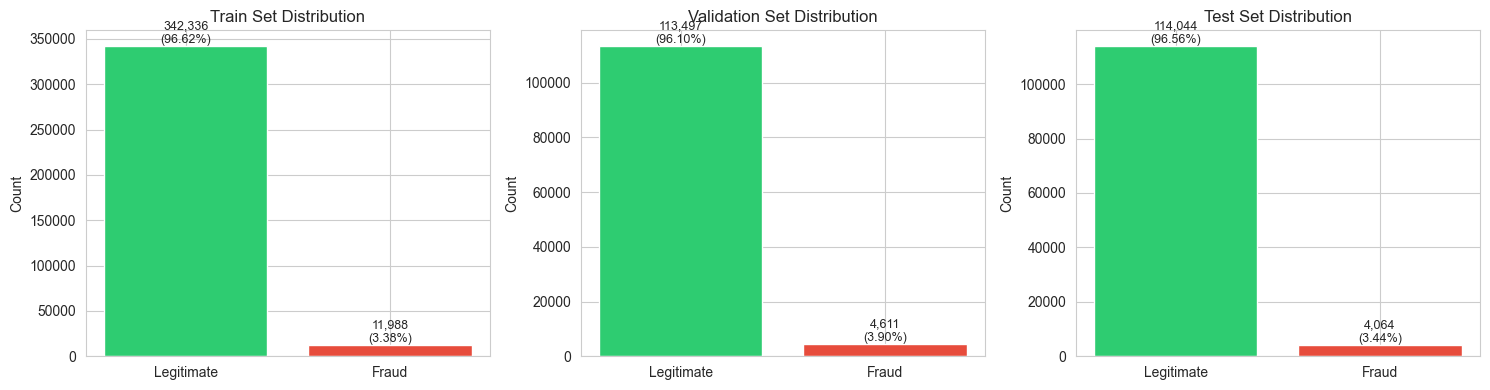

In [13]:
# Analyze class imbalance across splits
print(f"Class Imbalance Analysis\n")

# Calculate imbalance ratios
train_fraud_count = y_train.sum()
train_legit_count = len(y_train) - train_fraud_count
train_imbalance_ratio = train_legit_count / train_fraud_count

val_fraud_count = y_val.sum()
val_legit_count = len(y_val) - val_fraud_count
val_imbalance_ratio = val_legit_count / val_fraud_count

test_fraud_count = y_test.sum()
test_legit_count = len(y_test) - test_fraud_count
test_imbalance_ratio = test_legit_count / test_fraud_count

print("Training set:")
print(f" - Fraud cases: {train_fraud_count:,} ({y_train.mean()*100:.2f}%)")
print(f" - Legitimate cases: {train_legit_count:,} ({1 - y_train.mean()*100:.2f}%)")
print(f" - Imbalance ratio: 1:{train_imbalance_ratio:.1f}")

print("\nValidation set:")
print(f" - Fraud cases: {val_fraud_count:,} ({y_val.mean()*100:.2f}%)")
print(f" - Legitimate cases: {val_legit_count:,} ({1 - y_val.mean()*100:.2f}%)")
print(f" - Imbalance ratio: 1:{val_imbalance_ratio:.1f}")

print("\nTest set:")
print(f" - Fraud cases: {test_fraud_count:,} ({y_test.mean()*100:.2f}%)")
print(f" - Legitimate cases: {test_legit_count:,} ({1 - y_test.mean()*100:.2f}%)")
print(f" - Imbalance ratio: 1:{test_imbalance_ratio:.1f}")

# Visualize class distribution
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for idx, (split_name, y_split) in enumerate([('Train', y_train), ('Validation', y_val), ('Test', y_test)]):
    counts = y_split.value_counts()
    axes[idx].bar(['Legitimate', 'Fraud'], [counts[0], counts[1]], color=['#2ecc71', '#e74c3c'])
    axes[idx].set_title(f'{split_name} Set Distribution')
    axes[idx].set_ylabel('Count')
    axes[idx].ticklabel_format(style='plain', axis='y')

    # Add percentage labels
    total = len(y_split)
    for i, count in enumerate(counts):
        pc = (count / total) * 100
        axes[idx].text(i, count, f'{count:,}\n({pc:.2f}%)', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

### Imbalance Handling Strategy

We use **class weights** as our primary approach:

**Why Class Weights:**
- Preserves original data distribution (no synthetic data)
- Fast training (no data augmentation overhead)
- Industry standard for fraud detection in payments
- Maintains interpretability for regulatory compliance

**Alternative Approaches:**
- **SMOTE**: Considered if recall is insufficient with class weights alone
- **Undersampling**: Not appropriate for our dataset size (would discard valuable legitimate transaction patterns)

Class weights will be passed to LightGBM via the `is_unbalance=True` parameter, which automatically adjusts sample weights during training to balance the loss function.

In [15]:
# Calculate scale_pos_weight for reference (used in XGBoost)
# scale_pos_weight = (negative samples) / (positive samples)
scale_pos_weight_train = train_legit_count / train_fraud_count

print("Class Weight Configuration\n")
print(f"Calulcated scale_pos_weight: {scale_pos_weight_train:.2f}")
print(f"Interpretation: Fraud cases weighted {scale_pos_weight_train:.1f}x more than legitimate cases")

print("\nLightGBM Configuration:")
print(f" - Parameter: is_unbalance=True")
print(f" - Effect: Automatically adjusts sample weights based on class distribution")
print(f" - Benefits: Prevents bias toward majority class without data modification")

print("\nTraining with Class Weights:")
print(f" - Loss function penalizes fraud misclassification more heavily")
print(f" - Model learns to identify fraud patterns despite rarity")
print(f" - Maintains original data distribution for validation")

# Store imbalance metadata for model documentation
imbalance_metadata = {
    "strategy": "class_weights",
    "method": "lightgbm_is_unbalance",
    "scale_pos_weight_train": float(scale_pos_weight_train),
    "imbalance_ratios": {
        "train": float(train_imbalance_ratio),
        "val": float(val_imbalance_ratio),
        "test": float(test_imbalance_ratio)
    },
    "fraud_counts": {
        "train": int(train_fraud_count),
        "val": int(val_fraud_count),
        "test": int(test_fraud_count)
    },
    "fraud_rates": {
        "train": float(y_train.mean()),
        "val": float(y_val.mean()),
        "test": float(y_test.mean())
    }
}

# Save imbalance handling metadata
IMBALANCE_METADATA_PATH = PROCESSED_DIR / "imbalance_metadata.json"
with open(IMBALANCE_METADATA_PATH, "w") as f:
    json.dump(imbalance_metadata, f, indent=4)
    
print(f"\nImbalance metadata saved to: {IMBALANCE_METADATA_PATH}")

Class Weight Configuration

Calulcated scale_pos_weight: 28.56
Interpretation: Fraud cases weighted 28.6x more than legitimate cases

LightGBM Configuration:
 - Parameter: is_unbalance=True
 - Effect: Automatically adjusts sample weights based on class distribution
 - Benefits: Prevents bias toward majority class without data modification

Training with Class Weights:
 - Loss function penalizes fraud misclassification more heavily
 - Model learns to identify fraud patterns despite rarity
 - Maintains original data distribution for validation

Imbalance metadata saved to: /Users/joekariuki/Documents/Research/Projects/devbrew-payments-fraud-sanctions/data_catalog/processed/imbalance_metadata.json
